Copyright 2018, Skoltech DeepQauntum Labs, All rights reserved.

Let $n$ be the number of qubits and let $N=2^n$ be the size of the search space. We are searching for a particular bitstring $\omega = \omega_1, \omega_2, \omega_3, ..., \omega_n$. We define a pair of rank-$1$ projectors.
\begin{align}
  \label{def:omega-op}
  P_{\omega} &= |\omega\rangle\langle\omega|\\
  \label{def:plus-op}
  P_{+} &= |+ \rangle\langle +|^{\otimes n} = |s\rangle\langle s|
\end{align}
where $|s\rangle=\frac{1}{\sqrt{N}}\sum_{x\in \left\{0,1\right\}^n} |x\rangle$. To find $|\omega\rangle$, we consider a split-operator variational ansatz, formed by sequencing a pair of operators. These operators prepare a state $|\varphi(\alpha, \beta)\rangle$, with vectors $\alpha = \alpha_1, \alpha_2, ..., \alpha_p$ and $\beta=\beta_1, \beta_2, ..., \beta_p$. We seek to minimize the orthogonal complement of the subspace for the searched string $\omega$.
\begin{align}
\label{eq:projector-w}
P_{\omega^{\perp}} &= I - P_{\omega}
\end{align}
We sometimes call $P_{+}$ the driver Hamiltonian or diffusion operator.
The state $|\varphi(\alpha, \beta)\rangle$ is varied to minimize this orthogonal component.
\begin{align}
\label{eq:minimization}
\min_{\alpha,\beta} \langle \varphi(\alpha, \beta)|P_{\omega^{\perp}}|\varphi(\alpha,\beta)\rangle \geq \min_{|\phi\rangle} \langle \phi|P_{\omega^{\perp}}|\phi\rangle
\end{align}
To prepare the state we develop the sequence
\begin{align}
\label{state_prep}
|\varphi(\alpha,\beta)\rangle = \mathcal{K}(\beta_p) \mathcal{V}(\alpha_p)\cdots\mathcal{K}(\beta_1)\mathcal{V}(\alpha_1)|s\rangle.
\end{align}
Where the operators are defined as
\begin{align}
\label{eq:operator-v}
\mathcal{V}(\alpha) &:= e^{\imath \alpha P_{\omega}}\\
\label{eq:operator-k}
\mathcal{K}(\beta) &:= e^{\imath \beta P_{+}}
\end{align}
The length of the sequence is $2p$, for integer $p$.
We consider now the following problems on which the variational algorithm will work.

### Problem
Write a program which minimizes $\langle \varphi(\alpha, \beta)|P_{\omega^{\perp}}|\varphi(\alpha,\beta)\rangle$  over angles $\beta = (\beta_1, ..., \beta_p)$ and $\alpha = (\alpha_1 , ..., \alpha_p)$ for different $p$. 

Plot overlap between state $|\omega\rangle$ and $|\varphi(\alpha, \beta)\rangle$ with optimal angles for different $p \in[1,2,3,4,5,6]$ for $\omega=0101$:
$$
P_{\alpha,\beta}=|\langle \omega|\varphi(\alpha, \beta)\rangle|^2
$$

In [1]:
# import all necessary modules
import numpy as np
import scipy.linalg as la
import scipy.sparse as sparse
import scipy.sparse.linalg as lasp
import scipy
from scipy import optimize

In [2]:
def plus_state(n_qubits):
    """Returns state $|+>^{\otimes n_qubits}$
    Args:
    ----------
        n_qubits (int): number of qubits

    Returns:
    ----------
        numpy array: state $|+>^{\otimes n_qubits}$ 

    """
    return np.array([1]*(2**n_qubits))/np.sqrt(2**n_qubits)

In [3]:
def H_operator(target_state):
       return -np.outer(target_state, target_state)

In [4]:
def B_operator(n_qubits):
    return -np.outer(plus_state(n_qubits),plus_state(n_qubits))

In [5]:
def qaoa_step(state, H, n_qubits, params):
    """Returns a result of one QAOA step
    $e^{-1j*params[1]*B}e^{1j*params[0]*H}|state>$

    Args:
    ----------
        state (array): state  
        H (array): Hamiltonian of interest
        n_qubits (int): number of qubits
        params: parameters of step

    Returns:
    ----------
        scipy sparse array: state after application of $e^{-1j*params[1]*B}e^{1j*params[0]*H}|state>$
    """
    B=B_operator(n_qubits)
    state=(la.expm(-1j*params[0]*H)).dot(state)
    return (la.expm(-1j*params[1]*B)).dot(state)  

In [6]:
def cost_function(H, n_qubits, p, params):
    """Returns cost function of QAOA and QAOA state
    Args:
    ----------
        H (array): Hamiltonian of interest
        n_qubits (int): number of qubits
        p (int):    number of QAOA steps
        params: parameters of QAOA ($\alpha_1, \beta_1,\ldots, \alpha_n, \beta_n$)

    Returns:
    ----------
        number (float): value of cost function
        numpy array: state

    """
    ini_state=plus_state(n_qubits)
    for i in range(p):
        ini_state=qaoa_step(ini_state,H,n_qubits,params=[params[2*i],params[2*i+1]])
    return ((ini_state.conjugate().T).dot(H.dot(ini_state))).real, ini_state

In [7]:
def get_params(H, n_qubits, p):
    """Returns optimal; parameters for QAOA
    
    Args:
    ----------
        H (array): Hamiltonian of interest
        n_qubits (int): number of qubits
        p (int):    number of QAOA steps

    Returns:
    ----------
        array: optimal parameters for QAOA
    """
#     function to optimimize
    def fun(x):
#         we minimize f to find max for F 
        return cost_function(H, n_qubits, p, params=x)[0]
# starting point
    params_0=[0.25*np.pi for i in range(2*p)]
    params_min=[0 for i in range(2*p)]
    params_max=[2*np.pi if i%2==0 else np.pi for i in range(2*p)]
    # the bounds required by L-BFGS-B
    bounds = [(low, high) for low, high in zip(params_min, params_max)]
# use method L-BFGS-B because the problem is smooth and bounded
    minimizer_kwargs = dict(method="L-BFGS-B", bounds=bounds)
    result = optimize.basinhopping(fun, params_0, minimizer_kwargs=minimizer_kwargs)
    return [result.x[i] for i in range(2*p)]

In [8]:
def overlap(target_state,state):
    projector=np.outer(target_state, target_state)
    return np.real((state.conj().T).dot(projector.dot(state)))

In [9]:
zero_state=np.array([[1],[0]])
one_state=np.array([[0],[1]])
s=np.kron(zero_state,np.kron(one_state,np.kron(zero_state,one_state)))

In [11]:
overlap_array=[]
p_array=[]
for i in range(1,6):
    st=cost_function(H_operator(s),4,i,get_params(H_operator(s), 4, i))[1]
    p_array.append(i)
    overlap_array.append(overlap(s,st))
    print('Iteration ', i)

Iteration  1
Iteration  2
Iteration  3
Iteration  4
Iteration  5


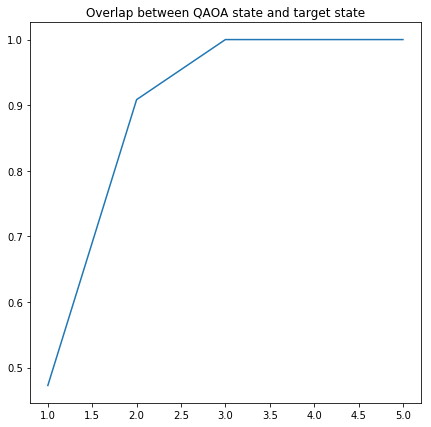

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(7,7))
plt.plot(p_array, overlap_array)
plt.title('Overlap between QAOA state and target state')

plt.show()